In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm import tqdm

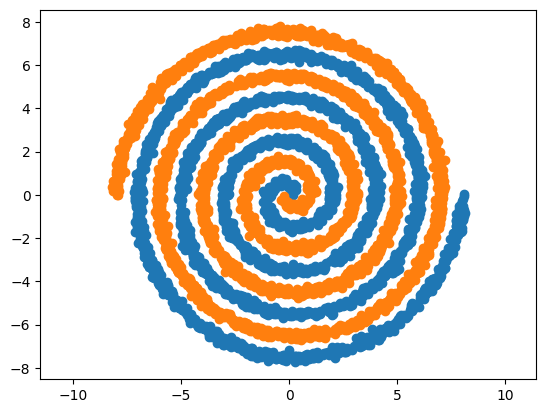

In [ ]:
R = 8
N = 3000

positive_r = np.random.triangular(0, R, R, N)
negative_r = np.random.triangular(0, R, R, N)

positive_x = positive_r * np.cos(positive_r * np.pi) + np.random.normal(0, 0.1, len(positive_r))
positive_y = positive_r * np.sin(positive_r * np.pi) + np.random.normal(0, 0.1, len(positive_r))
negative_x = -negative_r * np.cos(negative_r * np.pi) + np.random.normal(0, 0.1, len(negative_r))
negative_y = -negative_r * np.sin(negative_r * np.pi) + np.random.normal(0, 0.1, len(negative_r))

positive_label = np.ones_like(positive_x)
negative_label = np.zeros_like(negative_x)

positive_pos = np.stack((positive_x, positive_y), axis=1)
negative_pos = np.stack((negative_x, negative_y), axis=1)

spiral_X = np.concatenate((positive_pos, negative_pos), axis=0)
spiral_Y = np.concatenate((positive_label, negative_label), axis=0)

plt.scatter(positive_pos[:, 0], positive_pos[:, 1])
plt.scatter(negative_pos[:, 0], negative_pos[:, 1])
plt.axis('equal')
plt.show()

In [114]:
class SpiralDataset(Dataset):
    def __init__(self, spiral_X, spiral_Y):
        self.x = torch.tensor(spiral_X, dtype=torch.float32)
        self.y = torch.tensor(spiral_Y, dtype=torch.float32)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [115]:
train_idx, val_test_idx = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(spiral_X, spiral_Y).__next__()
train_X, train_Y = spiral_X[train_idx], spiral_Y[train_idx]
val_test_X, val_test_Y = spiral_X[val_test_idx], spiral_Y[val_test_idx]
val_idx, test_idx = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42).split(val_test_X, val_test_Y).__next__()
val_X, val_Y = val_test_X[val_idx], val_test_Y[val_idx]
test_X, test_Y = val_test_X[test_idx], val_test_Y[test_idx]

train_dataset = SpiralDataset(train_X, train_Y)
val_dataset = SpiralDataset(val_X, val_Y)
test_dataset = SpiralDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [116]:
device = "cuda"
class SimpleRegressor(torch.nn.Module):
    def __init__(self, arch_dim):
        super(SimpleRegressor, self).__init__()
        layers = []
        for i in range(len(arch_dim) - 1):
            if i > 0:
                # layers.append(torch.nn.Dropout(0.2))
                pass
            layers.append(torch.nn.Linear(arch_dim[i], arch_dim[i + 1]))
            if i < len(arch_dim) - 2:
                layers.append(torch.nn.ReLU())
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [174]:
model = SimpleRegressor([2, 32, 64, 32, 1])
summary(model, input_size=(32, 2), col_names=["input_size", "output_size", "num_params", "trainable"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleRegressor                          [32, 2]                   [32, 1]                   --                        True
├─Sequential: 1-1                        [32, 2]                   [32, 1]                   --                        True
│    └─Linear: 2-1                       [32, 2]                   [32, 32]                  96                        True
│    └─ReLU: 2-2                         [32, 32]                  [32, 32]                  --                        --
│    └─Linear: 2-3                       [32, 32]                  [32, 64]                  2,112                     True
│    └─ReLU: 2-4                         [32, 64]                  [32, 64]                  --                        --
│    └─Linear: 2-5                       [32, 64]                  [32, 32]                  2,080                     True
│    └─

In [118]:
arch = [2, 32, 64, 32, 1]
model = SimpleRegressor(arch)
model.to(device)
epoch = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=0.985,
    last_epoch=-1,
)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
avg_train_loss, avg_val_loss = [], []
pbar = tqdm(range(epoch))
for i in pbar:
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    avg_train_loss.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x).squeeze()
            val_loss += criterion(output, y).item()
        val_loss /= len(val_loader)
    avg_val_loss.append(val_loss)
    scheduler.step()
    pbar.set_description(f"Train Loss: {avg_train_loss[-1]:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Train Loss: 0.0080, Val Loss: 0.0121, LR: 0.000049: 100%|██████████| 200/200 [00:10<00:00, 19.25it/s]


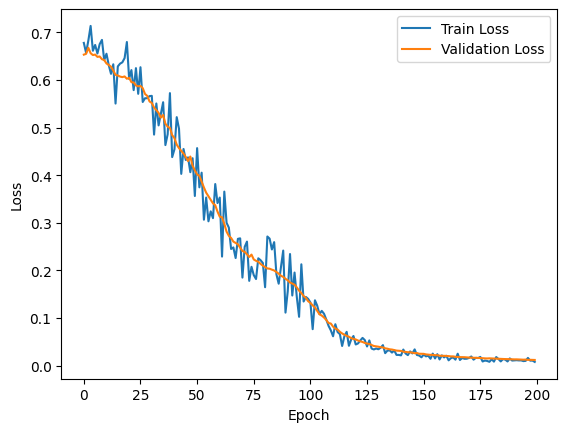

In [123]:
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [124]:
pos_arr = [[[], []], [[], []]]
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        output = model(x).squeeze()
        pred = torch.sigmoid(output) > 0.5
        pos_arr[int(y.item())][int(pred.item())].append(x[0].tolist())

Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


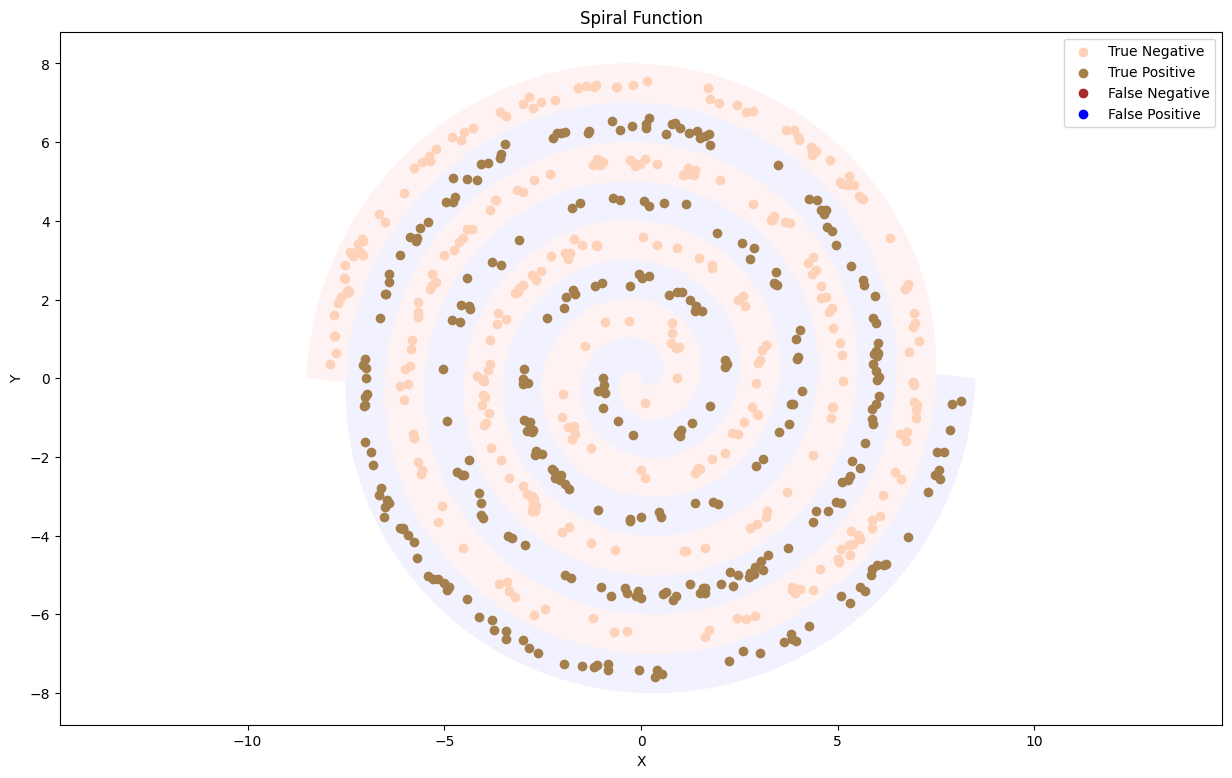

In [ ]:
[tn_p, fp_p], [fn_p, tp_p] = pos_arr
tn_p, fp_p, fn_p, tp_p = np.array(tn_p), np.array(fp_p), np.array(fn_p), np.array(tp_p)
tn, fp, fn, tp = len(tn_p), len(fp_p), len(fn_p), len(tp_p)
fp_p = fp_p.reshape(-1, 2)
fn_p = fn_p.reshape(-1, 2)
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}, Precision: {tp / (tp + fp):.4f}, Recall: {tp / (tp + fn):.4f}, F1 Score: {2 * tp / (2 * tp + fp + fn):.4f}")

NN = 1000
r = np.linspace(0, R + 0.5, NN)
x1 = r * np.sin(r * np.pi)
y1 = - r * np.cos(r * np.pi)

x2 = - r * np.sin(r * np.pi)
y2 = r * np.cos(r * np.pi)

plt.figure(figsize=(15, 9))
plt.title('Spiral Function')
poly_1_x = np.concatenate((x1, x2[int(NN*(R-0.5)//(R+0.5))::-1]))
poly_1_y = np.concatenate((y1, y2[int(NN*(R-0.5)//(R+0.5))::-1]))
plt.fill(poly_1_x, poly_1_y, color='blue', alpha=0.05, edgecolor='none')

poly_2_x = np.concatenate((x2, x1[int(NN*(R-0.5)//(R+0.5))::-1]))
poly_2_y = np.concatenate((y2, y1[int(NN*(R-0.5)//(R+0.5))::-1]))
plt.fill(poly_2_x, poly_2_y, color='red', alpha=0.05, edgecolor='none')

plt.scatter(tn_p[:, 0], tn_p[:, 1], color=[0.996, 0.82, 0.727], label='True Negative')
plt.scatter(tp_p[:, 0], tp_p[:, 1], color=[0.643, 0.498, 0.298], label='True Positive')
plt.scatter(fn_p[:, 0], fn_p[:, 1], color='brown', label='False Negative')
plt.scatter(fp_p[:, 0], fp_p[:, 1], color='blue', label='False Positive')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()